# Random Forest Classifier for Injection Molding of Bins using tsfresh data

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import my_preprocessing_functions as mpf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
import seaborn as sn
import os
from pprint import pp

In [2]:
filename = 'processed_data_pv_0.71.csv'
data_path = os.getcwd() + "/BalanceData/"
dataset_df = pd.read_csv(data_path + filename)

In [3]:
print('For the full dataset,')
mpf.check_imbalance(dataset_df['valid_or_not'])

For the full dataset,
The imbalance profile has:
 50.00% of valid products and     
 50.00% of invalid products


In [4]:
# Random Forest classificator evaluator function
def rfc_train_evaluator(model_rfc, Xtrain, ytrain, Xtest, ytest) -> tuple:
    model_rfc.fit(Xtrain, ytrain)
    mean_accuracy = model_rfc.score(Xtest, ytest) * 100
    y_predicted = model_rfc.predict(Xtest)
    return (mean_accuracy, y_predicted)

In [5]:
X = dataset_df.drop('valid_or_not', axis='columns')
y = dataset_df['valid_or_not']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2)

In [7]:
mpf.check_imbalance(y_train)
mpf.check_imbalance(y_test)

The imbalance profile has:
 49.02% of valid products and     
 50.98% of invalid products
The imbalance profile has:
 53.94% of valid products and     
 46.06% of invalid products


In [8]:
pilot_model_rfc = RandomForestClassifier(random_state=123)

In [9]:
r_pilot_accuracy, r_pilot_predictions = rfc_train_evaluator(pilot_model_rfc, X_train, y_train, X_test, y_test)
rcm = confusion_matrix(y_test, r_pilot_predictions)

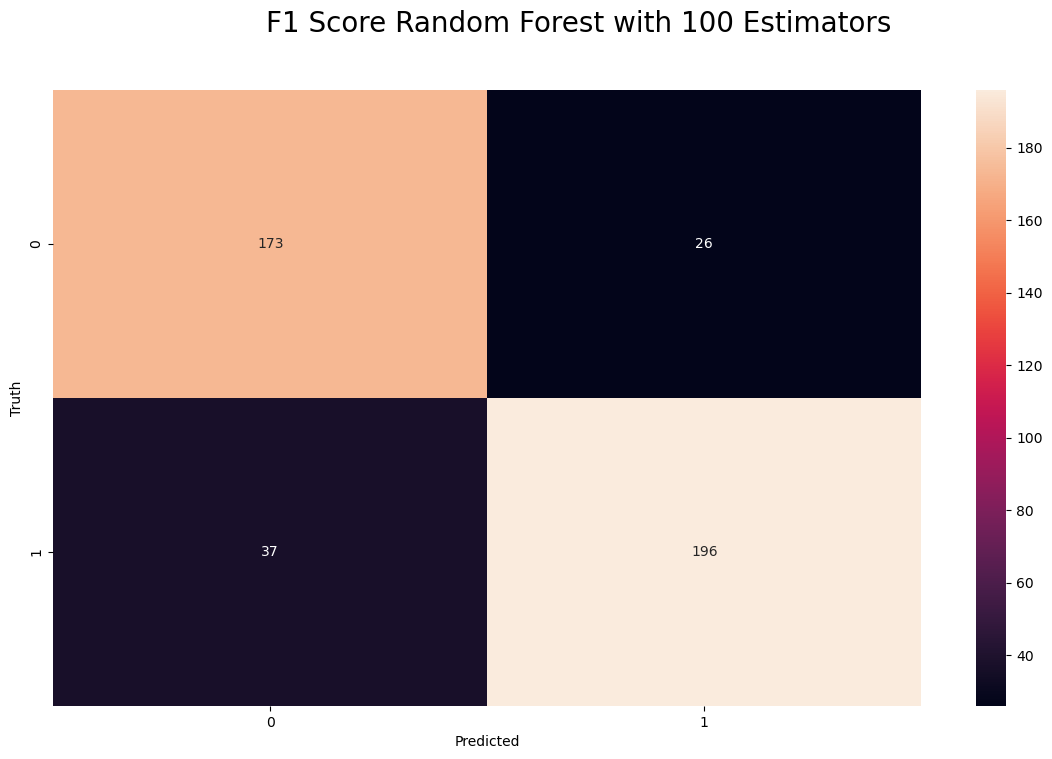

In [10]:
fig_rfc = plt.figure(figsize=[14, 8])
fs = 20  # fontsize
lw = 5  # linewidth
fig_rfc.suptitle("F1 Score Random Forest with 100 Estimators", fontsize=fs)
sn.heatmap(rcm, annot=True, fmt="")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

In [11]:
f1_rscores = f1_score(y_test, r_pilot_predictions, average=None)
print(f"The f1 scores for the not valid and valid classes are respectively {f1_rscores[0]:.2f} and {f1_rscores[1]:.2f}")

The f1 scores for the not valid and valid classes are respectively 0.85 and 0.86


## Grid Search and Cross-Validation (5-fold)

In [12]:
# number of trees in the forest
n_estimators = [x for x in range(10, 400, 10)]

# Check https://scikit-learn.org/stable/modules/tree.html#tree-mathematical-formulation
# gini index: works better for small datasets - based on rational ratios
# entropy: works better for bigger datasets - approach to continue uses log entropy
criterion = ["gini", "entropy", "log_loss"]

# max_features = [sqrt(n_features), log2(n_features)] at every split
# can introduce overfitting if number is too small
max_features = ["sqrt", "log2"]

# When False the whole dataset is used to build each tree, if True the dataset
# is resampled with replacement! -- Expect to perform worst when is True
bootstrap = [True, False]

In [13]:
param_grid = {
    'n_estimators': n_estimators,
    'criterion': criterion,
    'max_features': max_features,
    'bootstrap': bootstrap}
pp(param_grid, depth=1, width=36)
print(f"The total number of hyperparameter combination is: {len(n_estimators)*len(criterion)*len(max_features)*len(bootstrap)}")

{'n_estimators': [...],
 'criterion': [...],
 'max_features': [...],
 'bootstrap': [...]}
The total number of hyperparameter combination is: 468


In [14]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier(random_state=123)
# Random search of parameters, using 3 fold cross validation,
# search across 100 different combinations, and use all available cores
rf_grid = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    # n_iter=400,  # the size of random set choosen as new population
    cv=None,  # (None is 5-fold cv)
    verbose=0,  # more messages and feedback (the higher the more messages)
    # random_state=42,  # particular random seed given so this result can be reproduced
    n_jobs=-1)  # to give how many jobs can run in parallel (-1 means use all processors)
rf_grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(random_state=123), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2'],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200, 210, 220, 230,
                                          240, 250, 260, 270, 280, 290, 300, ...]})

In [15]:
rf_grid.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 'sqrt',
 'n_estimators': 250}

In [16]:
bne = rf_grid.best_params_['n_estimators']
bmf = rf_grid.best_params_['max_features']
bc = rf_grid.best_params_['criterion']
bb = rf_grid.best_params_['bootstrap']
best_rfc = RandomForestClassifier(n_estimators=bne,
                                  max_features=bmf,
                                  criterion=bc,
                                  bootstrap=bb)
best_rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=False, n_estimators=250)

In [17]:
best_accuracy, best_predictions = rfc_train_evaluator(best_rfc, X_train, y_train, X_test, y_test)
cm_best = confusion_matrix(y_test, best_predictions)

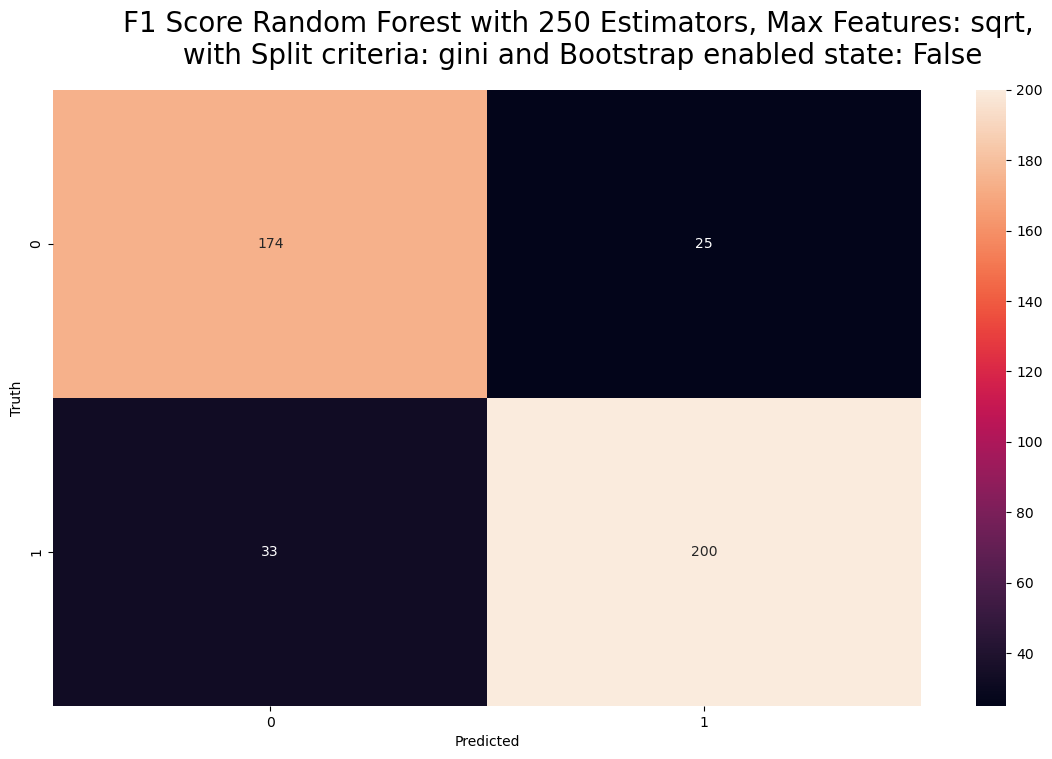

In [18]:
fig_best_rfc = plt.figure(figsize=[14, 8])
fs = 20  # fontsize
lw = 5  # linewidth
title = "F1 Score Random Forest with " + str(bne) + " Estimators" +\
    ", Max Features: " + bmf + \
    ",\n with Split criteria: " + bc + \
    " and Bootstrap enabled state: " + str(bb)
fig_best_rfc.suptitle(title, fontsize=fs)
sn.heatmap(cm_best, annot=True, fmt="")
plt.xlabel("Predicted")
plt.ylabel("Truth")
plt.show()

In [19]:
best_precisions = precision_score(y_test, best_predictions, average=None)
best_recalls = recall_score(y_test, best_predictions, average=None)
best_f1_scores = f1_score(y_test, best_predictions, average=None)

In [20]:
print(f"The best precission for the not valid and valid classes are \
          respectively {best_precisions[0]:.2f} and {best_precisions[1]:.2f}")
print(f"The best recall for the not valid and valid classes are \
    respectively {best_recalls[0]:.2f} and {best_recalls[1]:.2f}")
print(f"The best f1 scores for the not valid and valid classes are \
    respectively {best_f1_scores[0]:.2f} and {best_f1_scores[1]:.2f}")

The best precission for the not valid and valid classes are           respectively 0.84 and 0.89
The best recall for the not valid and valid classes are     respectively 0.87 and 0.86
The best f1 scores for the not valid and valid classes are     respectively 0.86 and 0.87


## Conclusions
- The smote oversampling technique allows to improve the minority class f1 score up to 82%.
- The SMOTE is based on knn and can help to produce new synthetic data by means of oversampling the minority class.
- `tsfresh` feature engineering performs slightly better than the `helper.py`